In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from einops import rearrange
from functools import partial
from omegaconf import OmegaConf
from pathlib import Path

from lpdm.data import field_preprocess, get_well_multi_dataset, isotropic_power_spectrum
from lpdm.diffusion import get_autoencoder

/mnt/home/frozet/mpp-ldm/lpdm/nn/attention.py:9: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  import xformers.components.attention.core as xfa


In [2]:
runpath = Path("/mnt/ceph/users/frozet/mpp-ldm/runs/fxeseb2g_f32c64_medium_soap_1e-05_0.0_cosine_1")  # fmt: off
cfg = OmegaConf.load(runpath / "config.yaml")
device = "cuda"

## Data

In [3]:
testset = get_well_multi_dataset(
    path="/mnt/ceph/users/polymathic/the_well/datasets",
    physics=cfg.dataset.physics,
    split="test",
    steps=1,
    include_filters=cfg.dataset.include_filters,
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

## Autoencoder

In [4]:
autoencoder = get_autoencoder(
    pix_channels=testset.metadata.n_fields,
    **cfg.ae,
)

state = torch.load(runpath / "state.pth", weights_only=True)

if "predictor" in state:
    autoencoder.load_state_dict(state["autoencoder"])
else:
    autoencoder.load_state_dict(state)

autoencoder.cuda()
autoencoder.eval()

AutoEncoder(
  (encoder): Encoder(
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ResBlock(
          (attn): Identity()
          (block): Sequential(
            (0): LayerNorm(dim=-3)
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Dropout(p=0.05, inplace=False)
            (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Sequential(
          (0): Patchify()
          (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x ResBlock(
          (attn): Identity()
          (block): Sequential(
            (0): LayerNorm(dim=-3)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Dropout(p=0.05, inplace=False)
   

In [5]:
sum(p.numel() for p in autoencoder.parameters())

337402116

## Evaluation

In [6]:
item = testset[42]
x = item["input_fields"]
x = x.to(device)
x = preprocess(x)
x = rearrange(x, "1 H W C -> 1 C H W")

with torch.no_grad():
    z = autoencoder.encode(x)
    y = autoencoder.decode(z)

x = x.cpu().squeeze(0)
z = z.cpu().squeeze(0)
y = y.cpu().squeeze(0)

In [7]:
error = (x - y).abs().reshape(testset.metadata.n_fields, -1)

In [8]:
error.mean(axis=-1)

tensor([0.0505, 0.0016, 0.0177, 0.0207])

In [9]:
error.median(axis=-1).values

tensor([0.0081, 0.0004, 0.0035, 0.0036])

In [10]:
error.max(axis=-1).values

tensor([2.0201, 0.0351, 0.3382, 0.4854])

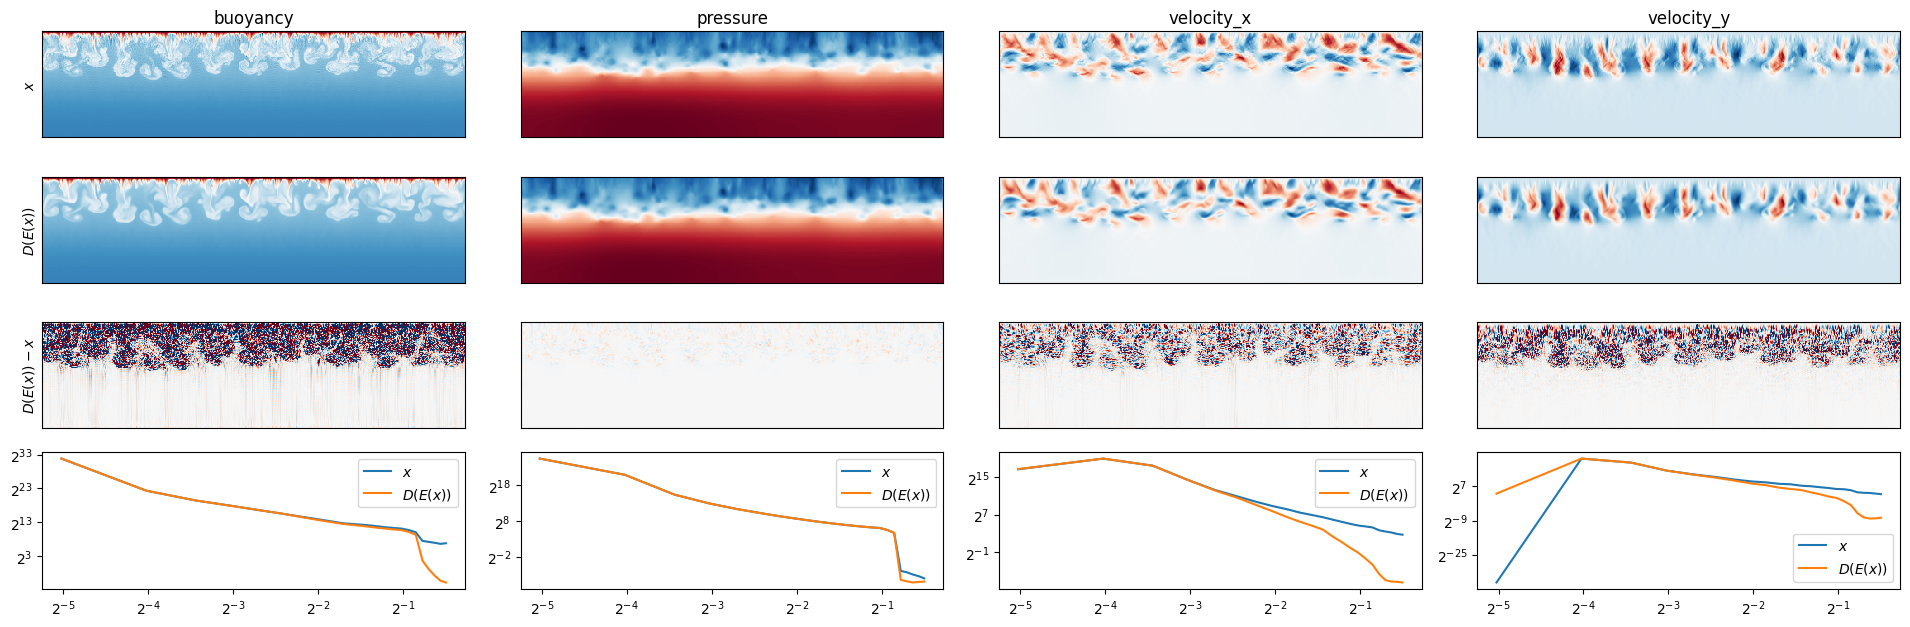

In [11]:
fig, axs = plt.subplots(
    nrows=4,
    ncols=testset.metadata.n_fields,
    figsize=(testset.metadata.n_fields * 4.8, 4 * 1.6),
)

axs[0, 0].set_ylabel("$x$")
axs[1, 0].set_ylabel("$D(E(x))$")
axs[2, 0].set_ylabel("$D(E(x)) - x$")

for field in range(testset.metadata.n_fields):
    vmin = np.nanmin(x[field])
    vmax = np.nanmax(x[field])

    axs[0, field].set_title(f"{cfg.dataset.fields[field]}")

    axs[0, field].imshow(x[field].T, cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax)
    axs[0, field].set_xticks([])
    axs[0, field].set_yticks([])

    axs[1, field].imshow(y[field].T, cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax)
    axs[1, field].set_xticks([])
    axs[1, field].set_yticks([])

    axs[2, field].imshow(
        y[field].T - x[field].T, cmap="RdBu_r", interpolation="none", vmin=-0.1, vmax=0.1
    )
    axs[2, field].set_xticks([])
    axs[2, field].set_yticks([])

    x_ps, x_edges = isotropic_power_spectrum(x[field], spatial=2)
    y_ps, y_edges = isotropic_power_spectrum(y[field], spatial=2)

    axs[3, field].loglog(x_edges[1:], x_ps, label="$x$", base=2)
    axs[3, field].loglog(y_edges[1:], y_ps, label="$D(E(x))$", base=2)
    axs[3, field].legend()

plt.tight_layout()